# Historical Time Series Analysis (1967 - 2020)
This notebook will presents a historical time series analysis using U.S. national aggregate data from 1967-2020. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

import statsmodels.api as sm
from linearmodels import PanelOLS

In [2]:
DATA_DIR = "../data/cleaned-data/"

In [3]:
data = pd.read_csv(DATA_DIR + "historical_time_series.csv")
data["DATE"] = data["DATE"].str.extract(r'(\d*)/').astype(int)
data.head()

,DATE,GDP,PI,PCEPILFE,GINI,RGDP,RPI
0,1967,859.95625,665.725000,19.314333,0.397,44.524252,34.467925
1,1968,940.64650,730.925000,20.147000,0.386,46.689160,36.279595
2,1969,1017.61500,800.350000,21.086583,0.391,48.258885,37.955414
3,1970,1073.31050,865.066667,22.074000,0.394,48.623290,39.189393
4,1971,1164.84975,932.775000,23.112417,0.396,50.399306,40.358177


In [7]:
print(data.describe().T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &         mean &          std &          min &          25\% &          50\% &           75\% &           max \\
\midrule
DATE     &   54.0 &  1993.500000 &    15.732133 &  1967.000000 &  1980.250000 &  1993.500000 &   2006.750000 &   2020.000000 \\
GDP      &   54.0 &  8590.962657 &  6346.633437 &   859.956250 &  2944.741687 &  7072.897500 &  14309.566000 &  21372.582250 \\
PI       &   54.0 &  7243.752314 &  5526.066567 &   665.725000 &  2394.012500 &  5802.512500 &  11862.193747 &  19627.583330 \\
PCEPILFE &   54.0 &    67.276434 &    29.295847 &    19.314333 &    41.734542 &    72.066250 &     92.072792 &    113.553250 \\
GINI     &   54.0 &     0.440000 &     0.032803 &     0.386000 &     0.404500 &     0.452000 &      0.467500 &      0.489000 \\
RGDP     &   54.0 &   108.899876 &    45.044777 &    44.524252 &    70.354690 &    98.123482 &    152.412090 &    190.897077 \\
RPI      &   54.0 &    91.009007 &    40.080154 &    34.467925

In [17]:
data_change = data.set_index(["DATE", "GINI"]).pct_change().dropna()
data_change = data_change.reset_index()
data_change.head()

,DATE,GINI,GDP,PI,PCEPILFE,RGDP,RPI
0,1968,0.386,0.093831,0.097938,0.043111,0.048623,0.052561
1,1969,0.391,0.081825,0.094982,0.046636,0.033621,0.046192
2,1970,0.394,0.054731,0.080860,0.046827,0.007551,0.032511
3,1971,0.396,0.085287,0.078269,0.047043,0.036526,0.029824
4,1972,0.401,0.098092,0.098291,0.032187,0.063850,0.064043


## Visualization

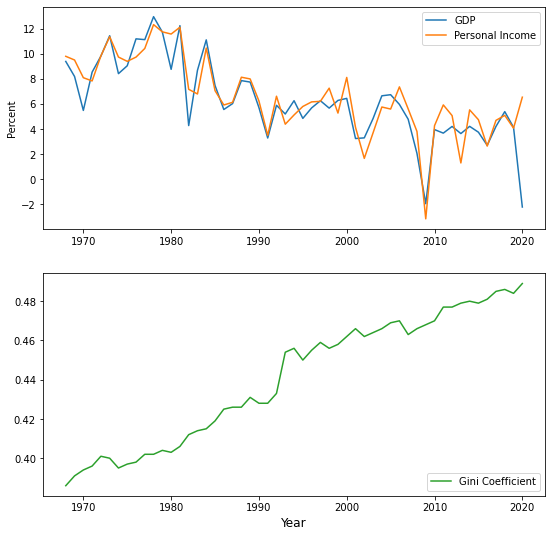

In [44]:
fig,(ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(9)
fig.set_figwidth(9)

ax1.plot(data_change.DATE, data_change.GDP * 100, label="GDP")
ax1.plot(data_change.DATE, data_change.PI * 100, label="Personal Income")
ax1.set_ylabel("Percent")
ax1.legend()

ax2.plot(data_change.DATE, data_change.GINI, color="tab:green", label="Gini Coefficient")
ax2.set_xlabel("Year", fontsize=12)
ax2.legend(loc=4)
plt.show()

## OLS Regression

In [64]:
data_change_regression = data_change.copy().iloc[:-1]
data_change_regression["GDP*GINI"] = data_change_regression["GDP"] * data_change_regression["GINI"]
data_change_regression["RGDP*GINI"] = data_change_regression["RGDP"] * data_change_regression["GINI"]
data_change_regression.set_index("DATE", inplace=True)
data_change_regression.head()

,GINI,GDP,PI,PCEPILFE,RGDP,RPI,GDP*GINI,RGDP*GINI
DATE,,,,,,,,
1968,0.386,0.093831,0.097938,0.043111,0.048623,0.052561,0.036219,0.018769
1969,0.391,0.081825,0.094982,0.046636,0.033621,0.046192,0.031994,0.013146
1970,0.394,0.054731,0.080860,0.046827,0.007551,0.032511,0.021564,0.002975
1971,0.396,0.085287,0.078269,0.047043,0.036526,0.029824,0.033774,0.014464
1972,0.401,0.098092,0.098291,0.032187,0.063850,0.064043,0.039335,0.025604


In [63]:
exog = sm.add_constant(data_change_regression[["GDP", "GDP*GINI"]])
model = sm.OLS(data_change_regression.PI, exog)
res = model.fit(cov_type="HC3")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     PI   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     128.3
Date:                Tue, 22 Mar 2022   Prob (F-statistic):           3.32e-20
Time:                        19:41:27   Log-Likelihood:                 158.65
No. Observations:                  52   AIC:                            -311.3
Df Residuals:                      49   BIC:                            -305.5
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.012      0.805      0.4

In [65]:
exog = sm.add_constant(data_change_regression[["RGDP", "RGDP*GINI"]])
model = sm.OLS(data_change_regression.RPI, exog)
res = model.fit(cov_type="HC3")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    RPI   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     32.71
Date:                Tue, 22 Mar 2022   Prob (F-statistic):           9.49e-10
Time:                        19:43:49   Log-Likelihood:                 162.88
No. Observations:                  52   AIC:                            -319.8
Df Residuals:                      49   BIC:                            -313.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.005      1.585      0.1